In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import pandas_profiling as pp
from scipy import stats, special
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta

In [2]:
pac17 = pd.read_csv('PAC_2018_12.csv', sep = ',', error_bad_lines = False, encoding = 'latin-1')
conversao_digs = pd.read_csv('conversao_digs.csv', sep = ',', error_bad_lines = False, encoding = 'utf8')
print('|rows:     | {}|\n|features: | {}   |'.format(pac17.shape[0], pac17.shape[1]))

|rows:     | 29345|
|features: | 16   |


# Descrição dos dados

# Pré-processamento dos Dados

A coluna *investimento_total* no dataset ```pac17``` contém incosistências de formatação com valores em vírgula e ponto. A célula abaixo troca ```,``` por ```.``` e converte o formato da coluna para numérico.

In [3]:
pac17['investimento_total'] = pac17.investimento_total.replace(',','.', regex=True).astype('float64')

In [4]:
def change_type_by_name(data, string, final_type):
    for col in data.columns:
        if string in col:
            data[col] = data[col].astype(final_type)
    return data
pac17 = change_type_by_name(pac17, 'idn_', 'object')

Considerando apenas os dados quem contém o código __BA__ na sigla do estado do empreendimento e desconsiderando os dados onde `sigla_uf` apresenta valores __NULL__.

In [5]:
pac17 = pac17.dropna(subset = ['sig_uf'])
pacba17 = pac17[pac17['sig_uf'].str.contains('BA')]

In [6]:
print('Obras no estado da Bahia sem valores de investimento: {:.2%}'.format(float(pacba17.investimento_total.isnull().sum())/pacba17.shape[0]))

Obras no estado da Bahia sem valores de investimento: 5.07%


In [7]:

pacba17['id_digs'] = pacba17['id_digs'].astype('category')
pacba17['id_digs'] = pacba17['id_digs'].map(lambda x: str(x)[:-2])
conversao_digs['id_digs'] = conversao_digs.id_digs.astype('str')

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
pacba17 = pacba17.join(conversao_digs.set_index('id_digs'), on='id_digs')

### Feature Engineering

In [9]:
pacba17['idn_estagio'] = pacba17.idn_estagio.astype('int')

In [10]:
pacba17['estagio'] = np.where(pacba17['idn_estagio'] >= 70, 'em_obras', 'nao_iniciado')
pacba17['estagio'] = np.where(pacba17['idn_estagio'] == 90, 'concluido', pacba17['estagio'])
pacba17 = pacba17.drop(columns=['idn_estagio'])

### Explorando a coluna `dat_selecao`

1. Preencher os 92 valores vazios no caso de obras concluídas a partir da mediana do número de obras.
2. Preecher os 121 valores vazios no caso de obras em andamento com a moda das datas de seleção (dia, mês, ano).
3. 192 valores vazios no caso de obras ainda não iniciadas.

In [11]:
def values_from_dates(df, column, day, month, year):
    df[day] = df[column].str.slice(0,2)
    df[month] = df[column].str.slice(3,5)
    df[year] = df[column].str.slice(6,10)
    return df
def conclusion_status(df, col):
    df[col] = np.where(df.dat_conclusao_revisada.notna(), 'sim', 'nao')
    return df

- Considera uma parte do dataset em que o estágio das obras é concluído e não há valores nulos na data de seleção.
- Confere que não há valores vazios em `dat_selecao` e `dat_conclusao_revisada`.
- Converte essas colunas para _datetime_.
- Calcula o número de dias das obras e guarda a sua __mediana__.

In [12]:
concluido = pacba17[(pacba17['estagio'] == 'concluido') & (pacba17.dat_selecao.notnull())]
assert concluido.dat_selecao.isnull().sum() == 0 and concluido.dat_conclusao_revisada.isnull().sum() == 0

In [13]:
concluido['dat_selecao'] = pd.to_datetime(concluido['dat_selecao'], dayfirst=True)
concluido['dat_conclusao_revisada'] = pd.to_datetime(concluido['dat_conclusao_revisada'], dayfirst=True)
concluido['dias_obra'] = (concluido['dat_conclusao_revisada'] - concluido['dat_selecao']).dt.days
concluido_median = int(concluido['dias_obra'].median())
del(concluido)

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Substitui os valores vazios da `dat_seleção` pela __moda__ onde o `estagio` é diferente de concluído.

In [14]:
nao_concluido_moda = pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.notnull())].mode()
pacba17['dat_selecao'][(pacba17['estagio'] != 'concluido') & (pacba17.dat_selecao.isnull())] = str(nao_concluido_moda[0])
pacba17['dat_conclusao_revisada'] = pacba17['dat_conclusao_revisada'].fillna(pacba17['dat_selecao'])
assert pacba17.dat_conclusao_revisada.isnull().sum() == 0

/home/fguer/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
pacba17['dat_selecao'] = pd.to_datetime(pacba17['dat_selecao'], dayfirst=True)
pacba17['dat_conclusao_revisada'] = pd.to_datetime(pacba17['dat_conclusao_revisada'], dayfirst=True)
pacba17['dat_selecao'] = pacba17['dat_selecao'].fillna(pacba17['dat_conclusao_revisada'] - timedelta(days=concluido_median))
assert pacba17.dat_selecao.isnull().sum() == 0

Nova coluna com o número de dias de obra

In [16]:
pacba17['dias_obra'] = (pacba17['dat_conclusao_revisada'] - pacba17['dat_selecao']).dt.days

In [17]:
pacba17['dia_conclusao'] = pacba17.dat_conclusao_revisada.dt.day
pacba17['mes_conclusao'] = pacba17.dat_conclusao_revisada.dt.month
pacba17['ano_conclusao'] = pacba17.dat_conclusao_revisada.dt.year
pacba17['dia_selecao'] = pacba17.dat_selecao.dt.day
pacba17['mes_selecao'] = pacba17.dat_selecao.dt.month
pacba17['ano_selecao'] = pacba17.dat_selecao.dt.year
pacba17 = pacba17.drop(columns=['dat_conclusao_revisada','dat_selecao'])

### Missing values

#### Plota as colunas com missing values

In [18]:
def plot_missing(df):
    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    unique = df.nunique()
    dtypes = df.dtypes
    missing_value_data = pd.DataFrame({'column_name': columns,
                                     'percent_missing': percent_missing,
                                     'unique': unique,
                                     'types': dtypes})
    missing_value_data = missing_value_data[missing_value_data['percent_missing']>0]
    missing_value_data=missing_value_data.sort_values(by=['percent_missing'], ascending=False)
    
    plt.figure(figsize=(9, 6))
    ax = sns.barplot(x="column_name", y="percent_missing", hue='types', data=missing_value_data)
    ax.axhline(50, ls='--', color = 'r')
    ax.text(3,51,"50% of missing values", color = 'r')
    ax.set_title("Percentage of Missing Values by column")
    plt.xticks(rotation=45)
    print percent_missing
    plt.show()

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


idn_empreendimento     0.000000 
id_digs                0.000000 
titulo                 0.000000 
investimento_total     4.786273 
sig_uf                 0.000000 
txt_municipios         3.281156 
txt_executores         0.481638 
dsc_orgao              0.000000 
dat_ciclo              0.000000 
obra_latitude          5.207706 
obra_longitude         5.207706 
emblematica            99.187237
observacao             78.838049
tipo_empreendimento    0.000000 
subeixo                0.000000 
estagio                0.000000 
dias_obra              0.000000 
dia_conclusao          0.000000 
mes_conclusao          0.000000 
ano_conclusao          0.000000 
dia_selecao            0.000000 
mes_selecao            0.000000 
ano_selecao            0.000000 
dtype: float64


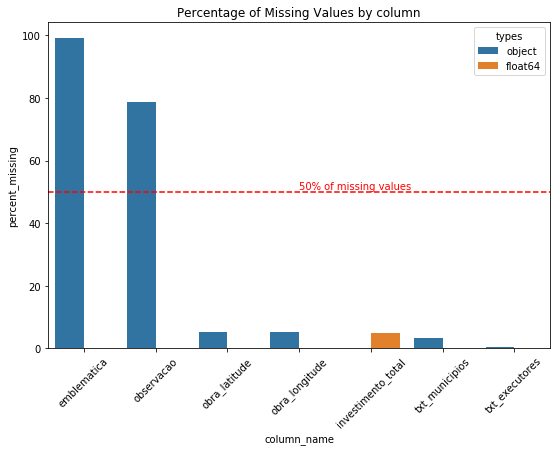

In [19]:
plot_missing(pacba17)

#### Exclusão das colunas com missing values acima de 50%

Dropa as colunas ``emblematica`` e ``observação`` dado o alto percentual de _missing values_

In [20]:
pacba17 = pacba17.drop(columns = ['emblematica', 'observacao'])
pacba17 = pacba17.dropna(subset=['obra_latitude', 'obra_longitude', 'dsc_orgao','txt_municipios', 'txt_executores'])

### Divisão do dataset para desenvolvimento e produção

Separação do dataset original para o dataset que será usado para treinar e testar o modelo e outro que será usado para o modelor estimar os valores de investimento.
- Critério de split:
    - Dataset de desenvolvimento: `investimento_total` diferentes de nulo;
    - Dataset para produção: `investimento_total` com valores nulo;

In [21]:
shape_dev = pacba17.shape[0]
pacba17 = pacba17.dropna(subset=['investimento_total'])
shape_prod = pacba17.shape[0]
dev = float(shape_prod)/(shape_dev)
prod = float(shape_dev - shape_prod)/(shape_dev)

In [22]:
print('{0:.0%} do dataset será usado para desenvolvimento e {1:.0%} como dados de previsão após finalização do modelo'.format(dev, prod))

98% do dataset será usado para desenvolvimento e 2% como dados de previsão após finalização do modelo


### Tratando outliers

#### `investimento_total`

Detectando Outliers a partir do __Z-score__

z = np.abs(stats.zscore(pacba17['investimento_total']))
print(np.where(z >0.5))

def logit(p):
    return np.log(p/(1 - p))

pacba17.log_investimento_total.value_counts(ascending=False)

In [23]:
z = np.abs(stats.zscore(pacba17.investimento_total))

In [24]:
pacba17 = pacba17[z<3]
#pacba17['log_investimento_total'] = stats.boxcox(pacba17.investimento_total, alpha=0.05)[0]
#pacba17['log_investimento_total'] = np.log(pacba17['investimento_total'])
pacba17['log_investimento_total'] = np.arcsinh(pacba17['investimento_total'])
pacba17.log_investimento_total

62       17.995727
196      17.029114
215      19.128421
223      17.673332
224      17.895966
255      15.676175
295      19.296149
303      19.296149
308      19.296149
343      13.592367
344      13.304685
345      13.304685
346      13.304685
347      13.928839
348      13.304685
349      13.304685
350      13.304685
351      13.592367
352      13.304685
353      13.592367
354      13.928839
355      14.656647
356      15.162891
357      13.304685
507      13.304685
508      13.592367
509      13.304685
510      13.304685
511      13.304685
512      13.928839
           ...    
27583    16.925113
27584    15.886274
27585    16.835979
27586    17.102352
27587    16.301961
27588    17.601469
27589    17.292921
27590    13.108729
27723    15.581657
27983    15.196290
28515    13.310497
28529    7.740578 
28537    11.352757
28547    6.284138 
28552    14.208747
28605    8.725832 
28613    9.472705 
28617    9.719084 
28618    11.919808
28802    13.864301
28803    13.507626
28804    13.

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


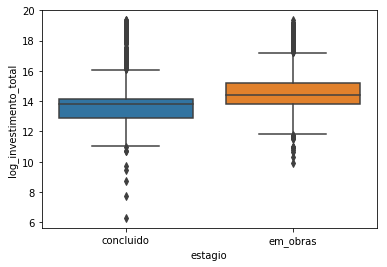

In [25]:
sns.boxplot(y=pacba17['log_investimento_total'], x=pacba17['estagio'])

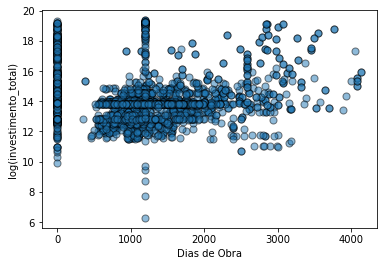

In [26]:
plt.scatter(pacba17['dias_obra'], pacba17['log_investimento_total'], alpha=0.5,edgecolors='black', s=50)
plt.xlabel('Dias de Obra')
plt.ylabel('log(investimento_total)')
plt.show()

/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/fguer/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'investimento_total')

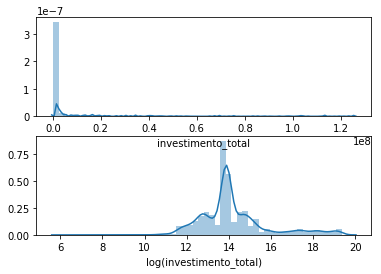

In [27]:
plt.subplot(2, 1, 2)
sns.distplot(pacba17['log_investimento_total'])
plt.xlabel('log(investimento_total)')
plt.subplot(2, 1, 1)
sns.distplot(pacba17['investimento_total'])
plt.xlabel('investimento_total')

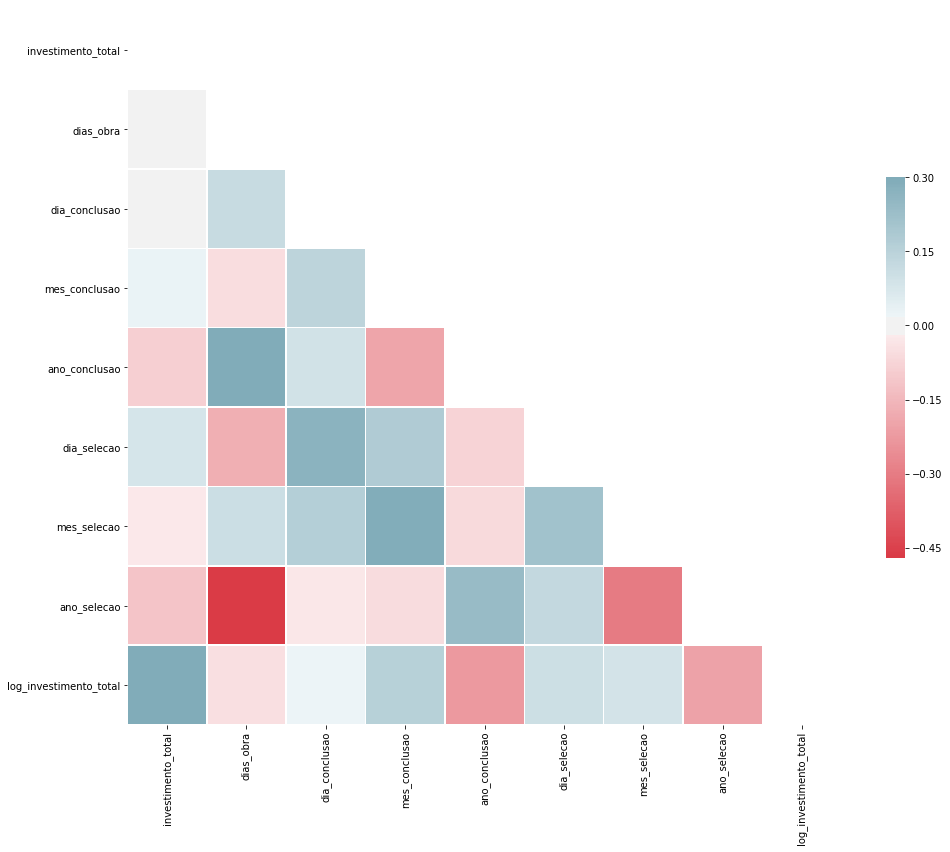

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

__Count de UFs__
- Criar coluna calculada com o número de estados.
- Dummificar essa coluna (?).

In [29]:
pacba17 = pacba17.drop(columns=['dat_ciclo'])

__Converte as colunas Latitude e Longitude de DMS para decimal__

Precisa ser completado: Splitar os campos com valores multiplos e aplicar a função de conversão

Dropa Colunas que serão utilizadas (ou não) porsteriormente:
- `sig_uf`: criar coluna calculada com número de estados.
- `txt_municipios`: criar coluna calculada com número de municípios.
- `obra_latitude`, `obra_longitude`: converter pra decimal.

In [30]:
pacba17 = pacba17.drop(columns = ['idn_empreendimento', 'titulo', 'sig_uf', 'txt_municipios', 'obra_latitude','obra_longitude'])

### Getting dummies

In [31]:
pacba17_dummies = pd.get_dummies(pacba17,columns=['dsc_orgao', 'tipo_empreendimento', 'subeixo', 'estagio', 'id_digs'], dummy_na=False)

#### WARNING!!!!!!
`txt_executores` com 82 valores únicos está sendo encoded!!

In [32]:
pacba17_dummies = pacba17_dummies.drop(columns=['txt_executores', 'investimento_total'])

Através da matriz de correlação, avaliando a relação entre a variável target `investimento_total` e as outras, percebe-se:
- Alta correlação negativa: Obras pertencentes ao subeixo de Infraestrutura Social apresentam menores 

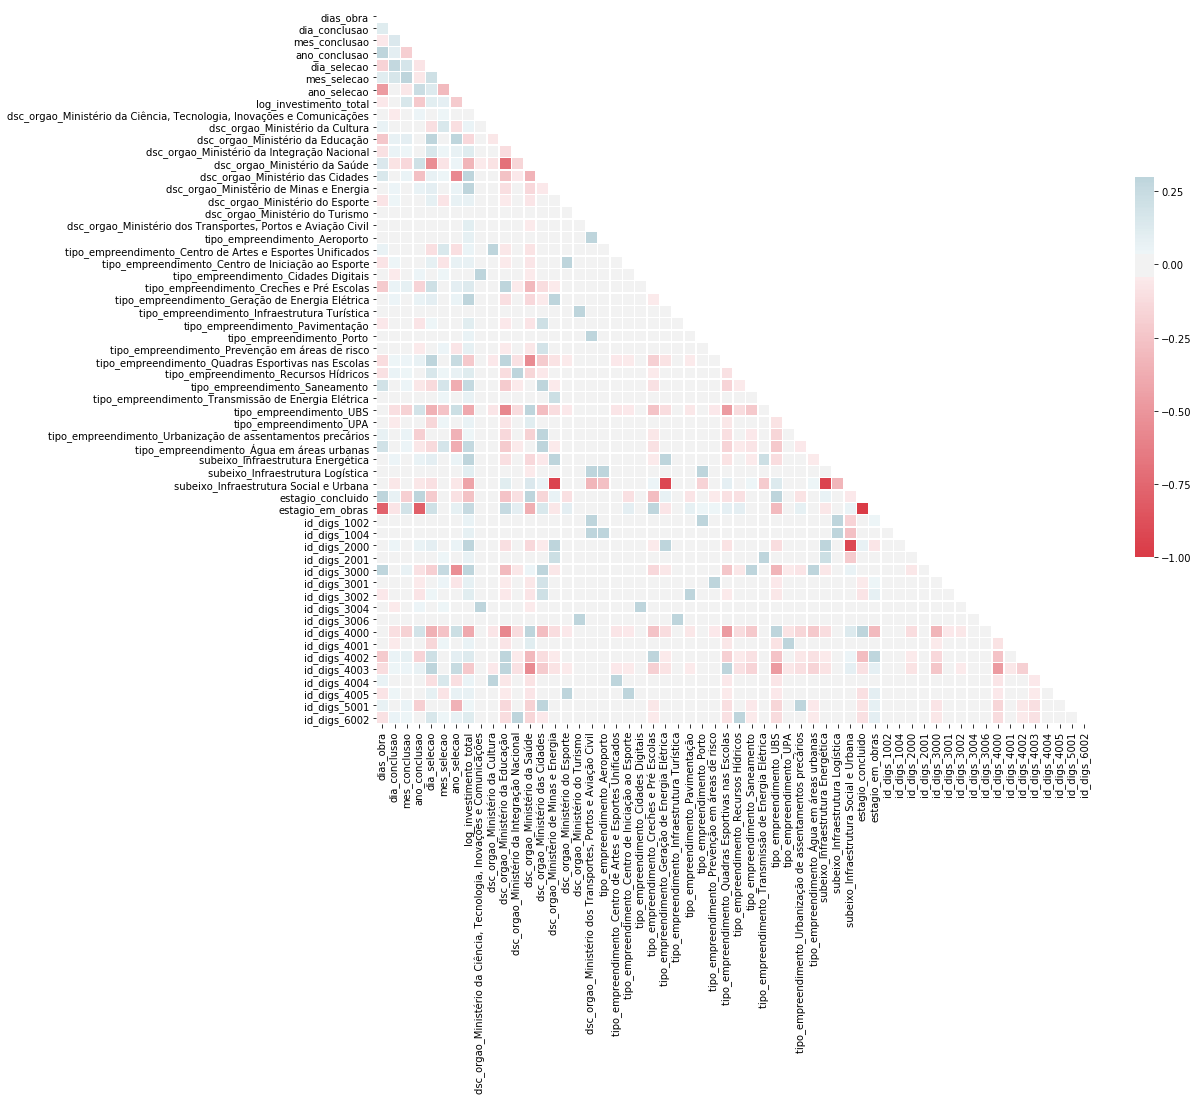

In [33]:
from matplotlib.pyplot import figure
figure(figsize=(16, 14))
corr = pacba17_dummies.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Shuffle and Split Data

In [34]:
features = pacba17_dummies.drop(columns='log_investimento_total')
prices = pacba17_dummies['log_investimento_total']

In [35]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.3, random_state=10)

print "Training and testing split was successful."

Training and testing split was successful.


/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Evaluation Metrics

1. Mean Absolute Error (MAE).
2. Mean Square Error (MSE).
3. Root Mean Square Error (RMSE).

In [36]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [37]:
def evaluate(X, Y,model):
    scores = ['neg_mean_absolute_error','neg_mean_squared_error','r2']
    results = 0
    for score in scores:
        results = cross_val_score(model, X, Y, cv=kfold, scoring=score)
        print('{}| mean {}| std {}'.format(score,results.mean(),results.std()))

In [38]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [39]:
LN = LinearRegression()
evaluate(features, prices, LN)

neg_mean_absolute_error| mean -0.715145312942| std 0.0340732038666
neg_mean_squared_error| mean -1.02241643017| std 0.157138322811
r2| mean 0.603311314946| std 0.0632723711741


#### Benchmark Model

In [40]:
LN.fit(X_train, y_train)
y_pred = LN.predict(X_test)

In [41]:
def evaluate_model(model, y, y_pred):
    assert len(y) == len(y_pred)
    print('-'*40)
    print(model)
    print('Mean Square Error:{:.2}'.format(mean_squared_error(y, y_pred)))
    print('Mean Absolute Error:{:.2}'.format(mean_absolute_error(y, y_pred)))
    print('Root Mean Square Error:{:.2}'.format(np.sqrt(mean_squared_error(y, y_pred))))

----------------------------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean Square Error:0.96
Mean Absolute Error:0.71
Root Mean Square Error:0.98


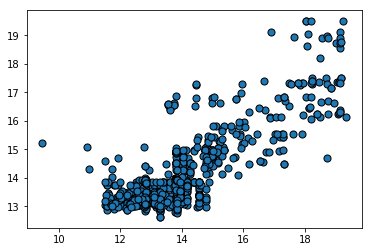

In [42]:
evaluate_model(LN,y_test, y_pred)
plt.scatter(y_test, y_pred,edgecolors='black', s=50)

## Model Selection

In [43]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [44]:
models = {"Linear Regression" : LinearRegression(),
"RandomForest_Regressor" : RandomForestRegressor(random_state = 42),
"SVRegressor" : SVR(),
"GradientBoosting_Regressor" : GradientBoostingRegressor(random_state = 42)}

In [45]:
for name, model in models.items():
    start = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    finish = datetime.now()
    evaluate_model(name, y_test, y_pred)
    print("Runnig time: {:.2}s".format((finish - start).total_seconds()))

----------------------------------------
RandomForest_Regressor
Mean Square Error:0.73
Mean Absolute Error:0.54
Root Mean Square Error:0.85
Runnig time: 0.11s
----------------------------------------
SVRegressor
Mean Square Error:1.3
Mean Absolute Error:0.7
Root Mean Square Error:1.1
Runnig time: 0.51s
----------------------------------------
GradientBoosting_Regressor
Mean Square Error:0.66
Mean Absolute Error:0.57
Root Mean Square Error:0.81
Runnig time: 0.31s
----------------------------------------
Linear Regression
Mean Square Error:0.96
Mean Absolute Error:0.71
Root Mean Square Error:0.98
Runnig time: 0.017s


### Tunning Model Parameters

In [46]:
from sklearn.model_selection import RandomizedSearchCV

#### Gradient Boosting Regressor

In [47]:
GBR=GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2500, presort='auto', random_state=42,
             subsample=1, verbose=0, warm_start=False)

----------------------------------------
GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=4,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=2500, presort='auto', random_state=42,
             subsample=1, verbose=0, warm_start=False)
Mean Square Error:0.62
Mean Absolute Error:0.54
Root Mean Square Error:0.79


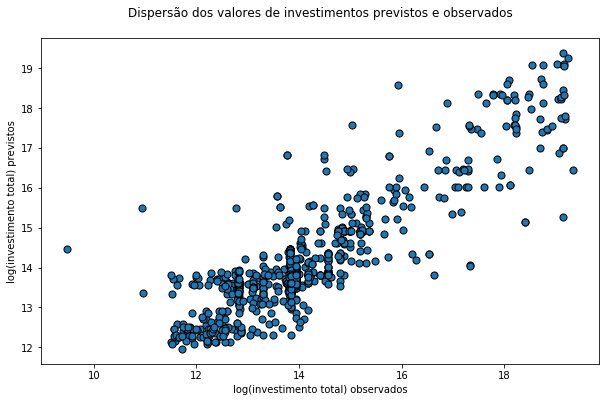

In [48]:
GBR.fit(X_train, y_train)
y_pred = GBR.predict(X_test)
plt.figure(figsize=[10,6])
plt.scatter(y_test, y_pred, edgecolors='black', s=50)
plt.title(u'Dispersão dos valores de investimentos previstos e observados\n')
plt.xlabel('log(investimento total) observados')
plt.ylabel('log(investimento total) previstos')
plt.savefig('fig/GBR_scatter.png')

evaluate_model(GBR, y_test, y_pred)

##### Feature Importance

In [49]:
feature_importances = pd.DataFrame(GBR.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances[feature_importances['importance']>0.01]

/usr/lib/python2.7/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


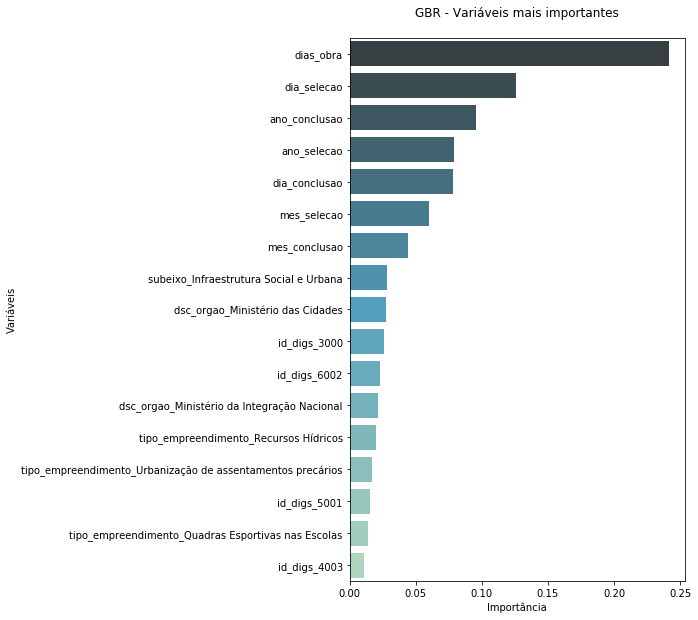

In [50]:
plt.figure(figsize=[6,10])
sns.barplot(y=feature_importances.index, x=feature_importances.importance, palette="GnBu_d")
plt.title(u'GBR - Variáveis mais importantes\n')
plt.xlabel(u'Importância')
plt.ylabel(u'Variáveis')
plt.savefig('./fig/GBR_feature_importance.png')

In [51]:
print(GBR.score(X_train,y_train))
print(GBR.score(X_test,y_test))

0.8399608665075577
0.7656116431439107


#### Support Vector Regressor

----------------------------------------
SVR(C=1.0, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Mean Square Error:1.3
Mean Absolute Error:0.7
Root Mean Square Error:1.1


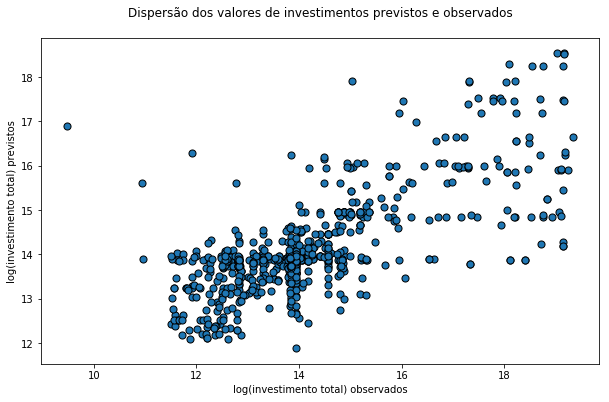

In [52]:
svr = SVR(C=1.0, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
plt.figure(figsize=[10,6])
plt.scatter(y_test, y_pred, edgecolors='black', s=50)
plt.title(u'Dispersão dos valores de investimentos previstos e observados\n')
plt.xlabel('log(investimento total) observados')
plt.ylabel('log(investimento total) previstos')
plt.savefig('./fig/SVR_scatter.png')

evaluate_model(svr, y_test, y_pred)

##### Score

In [53]:
print(svr.score(X_train,y_train))
print(svr.score(X_test,y_test))

0.7127243569359385
0.5195048933317568


#### Random Forest Regressor

14 minutes to run

----------------------------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Mean Square Error:0.65
Mean Absolute Error:0.53
Root Mean Square Error:0.81


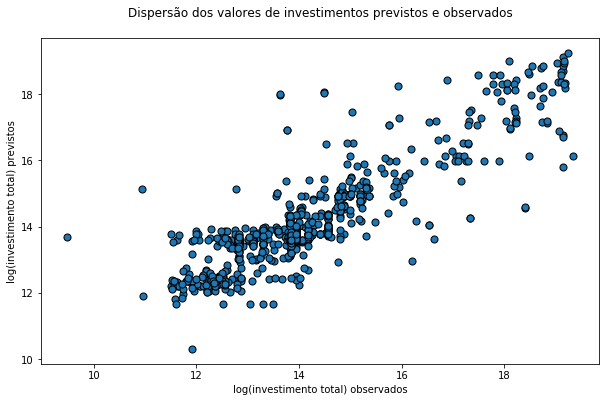

In [54]:
RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
plt.figure(figsize=[10,6])
plt.scatter(y_test, y_pred, edgecolors='black', s=50)
plt.title(u'Dispersão dos valores de investimentos previstos e observados\n')
plt.xlabel('log(investimento total) observados')
plt.ylabel('log(investimento total) previstos')
plt.savefig('./fig/RF_scatter.png')

evaluate_model(RF, y_test, y_pred)

##### Feature Importance

In [55]:
feature_importances = pd.DataFrame(RF.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances[feature_importances['importance']>0.01]

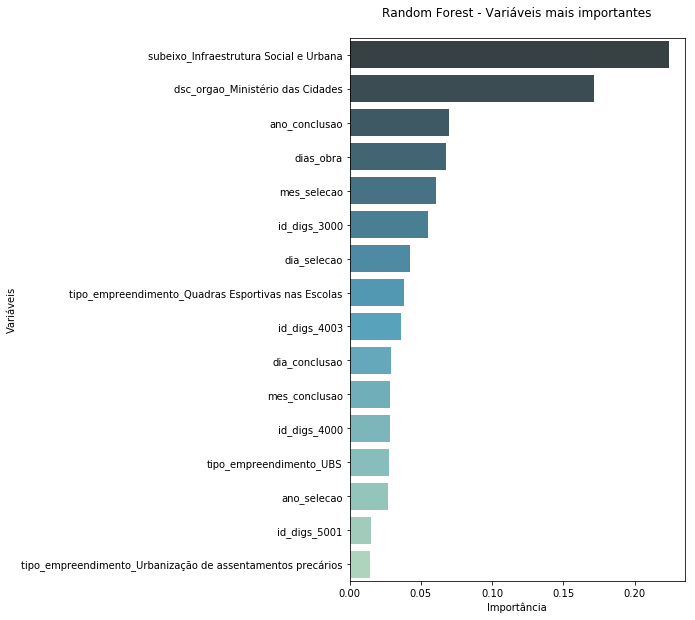

In [56]:
plt.figure(figsize=[6,10])
sns.barplot(y=feature_importances.index, x=feature_importances.importance, palette="GnBu_d")
plt.title(u'Random Forest - Variáveis mais importantes\n')
plt.xlabel(u'Importância')
plt.ylabel(u'Variáveis')
plt.savefig('./fig/RF_feature_importance.png')

##### Score

In [57]:
print(RF.score(X_train,y_train))
print(RF.score(X_test,y_test))

0.8713834843415001
0.7529084129359006


### Considerações Finais

In [58]:
#GBR = GradientBoostingRegressor(random_state = 42)
GBR.fit(X_train, y_train)
y_pred = GBR.predict(X_test)

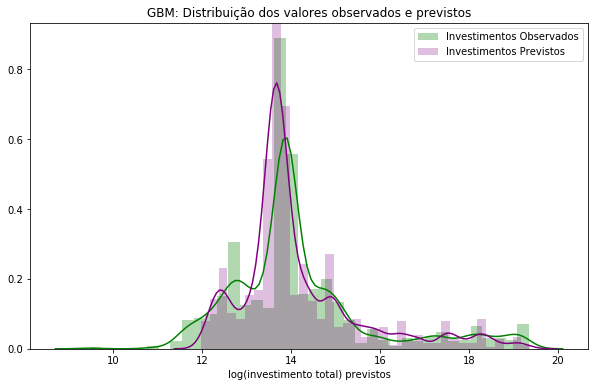

In [59]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=[10,6])
fig = sns.distplot(y_test, color='green', hist_kws=dict(alpha=0.3), label='Investimentos Observados').get_figure()
fig = sns.distplot(y_pred, color = 'purple', hist_kws=dict(alpha=0.25), label='Investimentos Previstos').get_figure()
plt.legend()
plt.xlabel('log(investimento total) previstos')
plt.title(u'GBM: Distribuição dos valores observados e previstos')
plt.show(fig)
fig.savefig('./fig/GBM_dist.png')

In [60]:
residuos = y_pred - y_test
avg = '%.*f' % (3, np.average(residuos))
avg = u'avg: ' + str(avg)
std = '%.*f' % (3, np.std(residuos))
std = u'std:   ' + str(std)

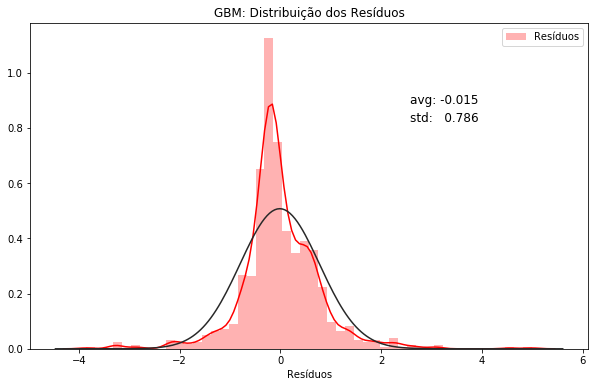

In [61]:
plt.figure(figsize=[10,6])
fig = sns.distplot(residuos, color='red', fit = norm,hist_kws=dict(alpha=0.3), label=u'Resíduos').get_figure()
plt.legend()
fig.text(0.7, 0.7, avg, size=12, ha='center', va='center')
fig.text(0.7, 0.66, std, size=12, ha='center', va='center')
plt.xlabel(u'Resíduos')
plt.title(u'GBM: Distribuição dos Resíduos')
plt.show(fig)
fig.savefig('./fig/GBM_residuos.png')

In [62]:
import statsmodels.api as sm

/usr/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<Figure size 720x432 with 0 Axes>

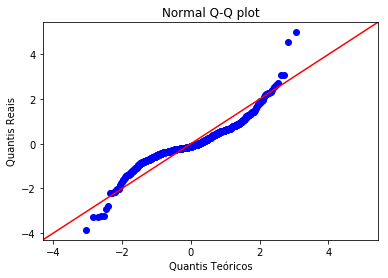

In [63]:
plt.figure(figsize=[10,6])
probplot = sm.ProbPlot(residuos)
fig = probplot.qqplot(line='45')
plt.title("Normal Q-Q plot")
plt.xlabel(u'Quantis Teóricos')
plt.ylabel('Quantis Reais')
plt.show()
fig.savefig('./fig/Q-Q_plot.png')

In [64]:
from scipy.stats import shapiro,normaltest, anderson

stat, p = normaltest(residuos)
print('Statistics=%.3f, p=%.40f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Resíduos seguem uma distribuição Gaussiana (Não Rejeita H0)')
else:
    print('Resíduos não seguem uma distribuição Gaussiana (Rejeita H0)')

Statistics=137.448, p=0.0000000000000000000000000000014240093098
Resíduos não seguem uma distribuição Gaussiana (Rejeita H0)


In [65]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.20f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Resíduos seguem uma distribuição Gaussiana (Não Rejeita H0)')
else:
    print('Resíduos não seguem uma distribuição Gaussiana (Rejeita H0)')

Statistics=0.912, p=0.00000000000000000000
Resíduos não seguem uma distribuição Gaussiana (Rejeita H0)


In [66]:
# normality test
result = anderson(residuos)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 19.221
15.000: 0.573, data does not look normal (reject H0)
10.000: 0.653, data does not look normal (reject H0)
5.000: 0.783, data does not look normal (reject H0)
2.500: 0.914, data does not look normal (reject H0)
1.000: 1.087, data does not look normal (reject H0)


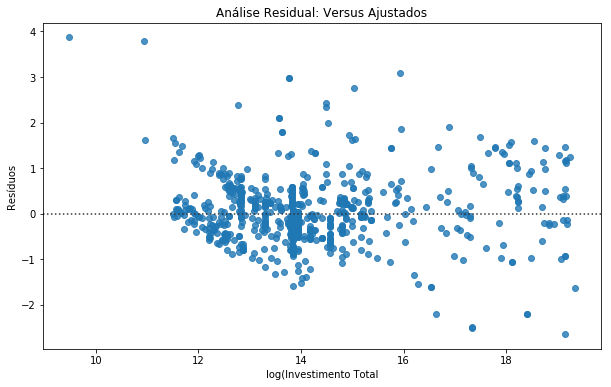

In [67]:
plt.figure(figsize=[10,6])
fig = sns.residplot(x=y_test, y=y_pred, lowess=False)
plt.title(u'Análise Residual: Versus Ajustados')
plt.xlabel(u'log(Investimento Total')
plt.ylabel(u'Resíduos')
plt.show()
fig = fig.get_figure()
fig.savefig('./fig/Residual_Pontos.png')

#### Tunando o Modelo